In [13]:
import pandas as pd
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import scipy.stats as stats
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import scikit_posthocs as sp
from Bio.SeqUtils import GC
import numpy as np
from collections import Counter, OrderedDict
from os import listdir

In [14]:
lsize=14
titlesize=16
axesthickness = 1.5
flierprops = dict(marker='o',markersize=1.5)
boxplot_kwargs = {'widths':0.65, 'vert':True, 'patch_artist':True, 'boxprops':dict(facecolor='#FEFBF3'), 'whis':[5, 95]}
bar_kwargs = {'color':'#C5DEFF', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
plt.rcParams['axes.linewidth'] = axesthickness
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

### Import list of all experiments

In [15]:
path='C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Various\\04_Lukas_Schmidheini\\Nuclease\\1422\\AnalysisFiles\\'

def list_files1(directory):
    return [f for f in listdir(directory) if '1422' in f]

sampledf = pd.DataFrame(columns=['filename','Cell_line','Editor','Replicate'])
filelist = list_files1(path)
sampledf['filename'] = filelist
sampledf['Library'] = sampledf['filename'].apply(lambda x: x.split('_')[1])
sampledf['Editor'] = sampledf['filename'].apply(lambda x: x.split('_')[2])
sampledf['Day'] = sampledf['filename'].apply(lambda x: x.split('_')[-1][1:-4] if not 'ctrl' in x else '')
sampledf['Editor_Day'] = sampledf.apply(lambda x: x.Editor+'_'+x.Day ,axis=1)
sampledf['Replicate'] = sampledf['filename'].apply(lambda x: x.split('_')[-2] if not 'ctrl' in x else x.split('_')[-1][:1])
sampledf['Control'] = sampledf['filename'].apply(lambda x: True if 'ctrl' in x else False)
sampledf['repname'] = sampledf.apply(lambda x: x.Editor+"_"+x.Day+"_"+x.Replicate,axis=1)
#sampledf['Cell_line_Editor'] = sampledf.apply(lambda x: x.Cell_line+"_"+x.Editor,axis=1)
#sampledf['repname'] = sampledf.apply(lambda x: x.Cell_line+"_"+x.Editor+"_"+x.Replicate,axis=1)

In [16]:
templatedf = pd.read_csv('C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Various\\04_Lukas_Schmidheini\\Nuclease\\1422\\Demultiplexed\\SpCas9_o1422.csv')

### Calculate control characteristics for each experimental setup

In [17]:
ctrllist = sampledf[sampledf['Editor'] == 'ctrl']
ctrldf = templatedf.copy()
for index, row in ctrllist.iterrows():
    controlrepdf = pd.read_csv(path+row.filename)
    ctrldf[row.repname+'_totalreads'] = controlrepdf['totalreads']
    controlrepdf['percentageindel'] = controlrepdf.apply(lambda x: (x.indelcount/x.totalreads)*100 ,axis=1)
    controlrepdf['percentageunedited'] = controlrepdf.apply(lambda x: (x.uneditedcount/x.totalreads)*100 ,axis=1)
    ctrldf[row.repname+'_percentageunedited'] = controlrepdf['percentageunedited']
    ctrldf[row.repname+'_percentageindel'] = controlrepdf['percentageindel']
    ctrldf[row.repname+'_uneditedcount'] = controlrepdf['uneditedcount']
    ctrldf[row.repname+'_indelcount'] = controlrepdf['indelcount']

for index, row in ctrllist.iterrows():    
    ctrldf = ctrldf[ctrldf[row.repname+'_totalreads'] > 100]
    ctrldf = ctrldf[ctrldf[row.repname+'_percentageindel'] < 30]

In [18]:
editordaylist = sampledf['Editor_Day'].unique()
editordaylist = [x for x in editordaylist if not 'ctrl' in x]
experimentdict = {}
for editor_day in editordaylist:
    experimentdf = templatedf.copy()
    for index, row in sampledf[sampledf['Editor_Day'] == editor_day].iterrows():
        dataframe = pd.read_csv(path+row.filename)
        dataframename = row.Editor+"_"+row.Day+"_"+row.Replicate
        experimentdf[dataframename+'_totalreads'] = dataframe['totalreads']
        dataframe['percentageindel'] = dataframe.apply(lambda x: (x.indelcount/x.totalreads)*100 ,axis=1)
        dataframe['percentageunedited'] = dataframe.apply(lambda x: (x.uneditedcount/x.totalreads)*100 ,axis=1)
        experimentdf[dataframename+'_percentageunedited'] = dataframe['percentageunedited']
        experimentdf[dataframename+'_percentageindel'] = dataframe['percentageindel']
        experimentdf[dataframename+'_uneditedcount'] = dataframe['uneditedcount']
        experimentdf[dataframename+'_indelcount'] = dataframe['indelcount']
    replicates = list(sampledf[sampledf['Editor_Day'] == editor_day].repname)
    controldf = sampledf[(sampledf['Editor'] == 'ctr')]
    #controlname = controldf['Cell_line_Editor'] + '_' + controldf['Replicate']
    
    ctrluneditedlist = []
    ctrlindellist = []
    lib = "1422"
    for index, row in ctrllist.iterrows():
        ctrluneditedlist.append(row.repname+'_percentageunedited')
        ctrlindellist.append(row.repname+'_percentageindel')
        
    experimentdf[lib+'_ctr'+'_percentageunedited'] = ctrldf[ctrluneditedlist].mean(axis=1)
    experimentdf[lib+'_ctr'+'_percentageindel'] = ctrldf[ctrlindellist].mean(axis=1)
    #print()
    #print(controlname)
    #print(cellline)
    cutoff = 100
    initialtemplen = len(experimentdf)
    #print('Total variants:',initialtemplen)
    for replicate in replicates:
        experimentdf = experimentdf[experimentdf[replicate+'_totalreads']>cutoff]

    experimentdict[editor_day] = experimentdf

### Calculate editing characteristics for all experimental setups
Also clip editing levels to be between 0-100.

In [19]:
sampledf_woctr = sampledf[sampledf['Editor'] != 'ctrl']

In [20]:
editordaydf = sampledf_woctr.copy()
editordaydf = editordaydf[editordaydf['Replicate'] == "1"]
editordaydf = editordaydf.set_index('Editor_Day')

cols = ['Editor', 'Library', 'Day']
editordaydf = editordaydf[cols]
editordaydf

,Editor,Library,Day
Editor_Day,,,
p614_10,p614,1422,10
p614_3,p614,1422,3
p614_5,p614,1422,5
p614_7,p614,1422,7
p615_10,p615,1422,10
p615_3,p615,1422,3
p615_5,p615,1422,5
p615_7,p615,1422,7
p616_10,p616,1422,10


In [21]:
for editor_day in experimentdict:
    print(editor_day)
    replicatelist = list(sampledf_woctr[sampledf_woctr['Editor_Day'] == editor_day]['repname'])
    ctrname = lib+'_ctr'
    
    for replicate in replicatelist:
        print(replicate)
        repnr = replicate.split('_')[-1]
        experimentdict[editor_day][replicate+'_percentageindel_corrected_individual'] = experimentdict[editor_day].apply(lambda x: ((x[replicate+'_percentageindel']-x[ctrname+'_percentageindel'])/((100-x[ctrname+'_percentageindel'])/100)),axis=1)
        editordaydf.at[editor_day,repnr +'_meanindel'] = None
        editordaydf.at[editor_day,repnr +'_meanindel'] = experimentdict[editor_day][[replicate +'_percentageindel_corrected_individual']].mean()
        
    allreps = []
    for index,row in sampledf_woctr[sampledf_woctr['Editor_Day'] == editor_day].iterrows():
        rep = row.Editor_Day+'_'+row.Replicate
        allreps.append(rep)
        
    print(allreps)    
    experimentdict[editor_day][editor_day+'_averageindel'] = experimentdict[editor_day][[x +'_percentageindel_corrected_individual' for x in allreps]].mean(axis=1)
    
       
    # Clip editing rates to be between 0 and 100
    experimentdict[editor_day][editor_day+'_averageindel'] = experimentdict[editor_day][editor_day+'_averageindel'].clip(0,100)
    
    experimentdict[editor_day] = experimentdict[editor_day].dropna(subset=[editor_day+'_averageindel'])
    
    replist = ['1_meanindel','2_meanindel','3_meanindel']
    
    editordaydf.at[editor_day,'numberofvariants'] = len(experimentdict[editor_day])
    editordaydf.at[editor_day,'meanindel'] = experimentdict[editor_day][editor_day+'_averageindel'].mean()
    editordaydf.at[editor_day,'standarddeviation'] = experimentdict[editor_day][editor_day+'_averageindel'].std()
    experimentdict[editor_day].to_csv('.//1422//AnalysisFiles//summary//20220912_'+editor_day+'_analysis_dataframe.csv')

p614_10
p614_10_1
p614_10_2
p614_10_3
['p614_10_1', 'p614_10_2', 'p614_10_3']
p614_3
p614_3_1
p614_3_2
p614_3_3
['p614_3_1', 'p614_3_2', 'p614_3_3']
p614_5
p614_5_1
p614_5_2
p614_5_3
['p614_5_1', 'p614_5_2', 'p614_5_3']
p614_7
p614_7_1
p614_7_2
p614_7_3
['p614_7_1', 'p614_7_2', 'p614_7_3']
p615_10
p615_10_1
p615_10_2
p615_10_3
['p615_10_1', 'p615_10_2', 'p615_10_3']
p615_3
p615_3_1
p615_3_2
p615_3_3
['p615_3_1', 'p615_3_2', 'p615_3_3']
p615_5
p615_5_1
p615_5_2
p615_5_3
['p615_5_1', 'p615_5_2', 'p615_5_3']
p615_7
p615_7_1
p615_7_2
p615_7_3
['p615_7_1', 'p615_7_2', 'p615_7_3']
p616_10
p616_10_1
p616_10_2
p616_10_3
['p616_10_1', 'p616_10_2', 'p616_10_3']
p616_3
p616_3_1
p616_3_2
p616_3_3
['p616_3_1', 'p616_3_2', 'p616_3_3']
p616_5
p616_5_1
p616_5_2
p616_5_3
['p616_5_1', 'p616_5_2', 'p616_5_3']
p616_7
p616_7_1
p616_7_2
p616_7_3
['p616_7_1', 'p616_7_2', 'p616_7_3']


In [22]:
for index, row in editordaydf.iterrows():
    editordaydf.at[index,'replicate_meanindel'] = (row['1_meanindel'] + row['2_meanindel'] + row['3_meanindel']) / 3
    editordaydf.at[index,'replicate_std'] = np.std([row['1_meanindel'],row['2_meanindel'],row['3_meanindel']])

In [23]:
editordaydf['Day'] = editordaydf['Day'].apply(lambda x: int(x))
editordaydf = editordaydf.sort_values('Day')
editordaydf = editordaydf.sort_values('Editor')
editordaydf['filename'] = editordaydf.apply(lambda x: '20220912_'+x.Editor+'_'+str(x.Day)+'_analysis_dataframe.csv',axis=1)
editordaydf.to_csv('.//1422//AnalysisFiles//summary//20220912_1422_summary_mean_std.csv')
editordaydf

,Editor,Library,Day,1_meanindel,2_meanindel,3_meanindel,numberofvariants,meanindel,standarddeviation,replicate_meanindel,replicate_std,filename
Editor_Day,,,,,,,,,,,,
p614_3,p614,1422,3,74.320857,72.594119,72.709565,91.0,73.208180,9.601462,73.208180,0.788191,20220912_p614_3_analysis_dataframe.csv
p614_5,p614,1422,5,85.720733,85.963802,85.569967,91.0,85.751501,5.600632,85.751501,0.162248,20220912_p614_5_analysis_dataframe.csv
p614_7,p614,1422,7,86.439658,86.530828,87.127514,91.0,86.699333,4.927827,86.699333,0.305049,20220912_p614_7_analysis_dataframe.csv
p614_10,p614,1422,10,87.915531,87.920107,87.882644,91.0,87.906094,5.735919,87.906094,0.016686,20220912_p614_10_analysis_dataframe.csv
p615_3,p615,1422,3,45.647868,41.018694,38.792191,91.0,41.819584,16.116025,41.819584,2.855538,20220912_p615_3_analysis_dataframe.csv
p615_5,p615,1422,5,60.007620,64.089463,60.884290,91.0,61.660458,18.894549,61.660458,1.754459,20220912_p615_5_analysis_dataframe.csv
p615_7,p615,1422,7,61.445503,63.349575,67.796060,91.0,64.197046,19.295237,64.197046,2.660959,20220912_p615_7_analysis_dataframe.csv
p615_10,p615,1422,10,50.651643,73.635905,51.651185,88.0,58.646245,19.844256,58.646245,10.607142,20220912_p615_10_analysis_dataframe.csv
p616_3,p616,1422,3,59.449893,60.661365,59.376656,91.0,59.836001,16.502558,59.829305,0.589115,20220912_p616_3_analysis_dataframe.csv


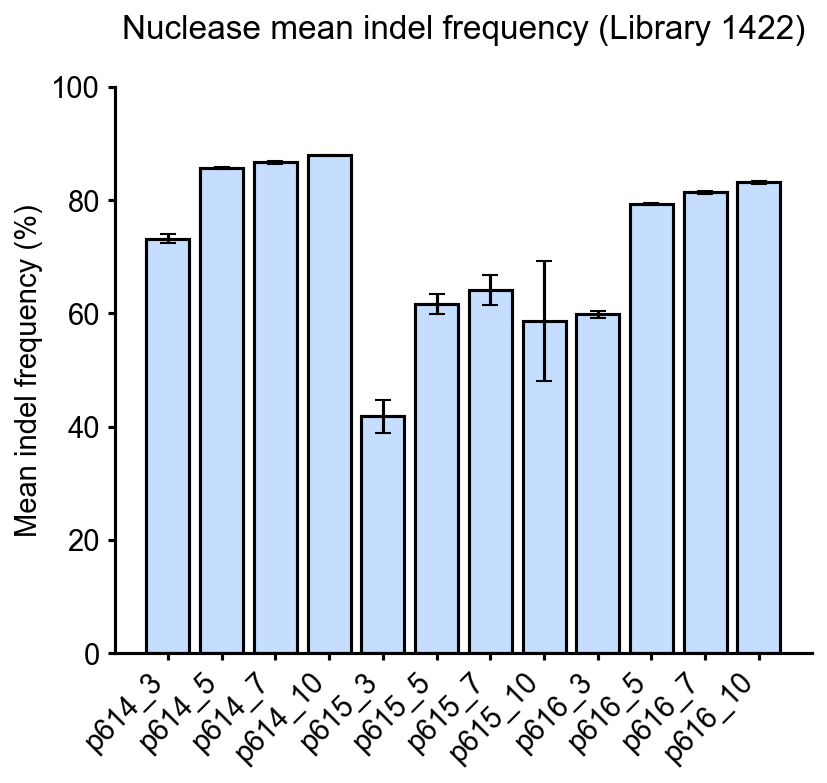

In [24]:
conditionlist = list(editordaydf.index)
meanlist = list(editordaydf.replicate_meanindel)
stdlist = list(editordaydf.replicate_std)

fig1, ax1 = plt.subplots(figsize = (6,5),dpi=150,sharex=True)
ax1.set_title('Nuclease mean indel frequency (Library 1422)\n', fontsize=titlesize)
ax1.bar(conditionlist,meanlist,yerr=stdlist, **bar_kwargs)
ax1.set_xticks(range(len(conditionlist)))
ax1.set_xticklabels(conditionlist, ha="right")
#ax1.set_yticks(np.linspace(0,1,11))
ax1.set_ylabel('Mean indel frequency (%)', fontsize=lsize)
ax1.tick_params(axis='x', labelsize= lsize, width=1.5, rotation=45)
ax1.tick_params(axis='y', labelsize= lsize, width=1.5)
ax1.set_ylim(0,100)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Various\\04_Lukas_Schmidheini\\Nuclease\\1422\\'
#plt.savefig(figurepath+'Nuclease_1422_meanefficiency.pdf', format='pdf',
#        transparent=True,bbox_inches='tight')